# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [1]:
import cv2, os 
import numpy as np 
import warnings 
warnings.filterwarnings("ignore")

## create a function to detect all landmarks in a given frame 

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [3]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  18%|█▊        | 19/108 [00:00<00:02, 30.76it/s]

failed on .DS_Store


control_videos:  23%|██▎       | 14/62 [00:00<00:03, 15.42it/s]

failed on .DS_Store


control_videos: 100%|██████████| 62/62 [00:03<00:00, 19.67it/s]


(97, 50)

In [4]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


In [8]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 90, 90, 49, 49, 90, 90, 90, 72, 90, 121, 49, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [5]:
# to balance classes 
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

## after balancing the classes, pad the data and convert to numpy arrays 

In [13]:
# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

NameError: name 'ARMFLAPPING_LOCATIONS' is not defined

In [13]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

## function below to plot the model accuracy + loss through training. 

In [3]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(test_frames)

## create the augmenter() class to do shift augmentations

In [4]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] 
        Y_locations = X[:, 42:84] 
        Z_locations = X[:, 84:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:, 42:84] + mask * tf.ones_like(X[:, 42:84]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:, 42:84] - mask * tf.ones_like(X[:, 42:84]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:, :42] + mask * tf.ones_like(X[:, :42]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:, :42] - mask * tf.ones_like(X[:, :42]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:, 84:] + mask * tf.ones_like(X[:, 84:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:, 84:] - mask * tf.ones_like(X[:, 84:]) * move_close)

        return X



class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

In [48]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('all_points_folds'): 
    with open(f"all_points_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [49]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[:, column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = (1, 0)) 
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [50]:
X = interp_X(X)

(100, 90, 126)


## functions to plot the ROC and AURROC bar graph for each fold in a run, and for each run

In [7]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

## k-fold cross validation shown below

In [8]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [51]:
import random 
def shuffle(X, y, seed = None):
    if not seed:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 126)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y, seed=65)

In [52]:
import tensorflow as tf 
def make_model(): 
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model 

## run 10 times to gather results!

Epoch 1/75
3/3 [==============================] - 1s 266ms/step - loss: 0.6955 - accuracy: 0.6125 - precision_69: 0.6341 - recall_69: 0.6190 - val_loss: 0.7043 - val_accuracy: 0.5500 - val_precision_69: 0.4000 - val_recall_69: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6856 - accuracy: 0.6125 - precision_69: 0.6486 - recall_69: 0.5714 - val_loss: 0.6935 - val_accuracy: 0.7000 - val_precision_69: 0.6250 - val_recall_69: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6737 - accuracy: 0.6625 - precision_69: 0.6531 - recall_69: 0.7619 - val_loss: 0.6830 - val_accuracy: 0.7000 - val_precision_69: 0.6250 - val_recall_69: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6663 - accuracy: 0.6875 - precision_69: 0.6545 - recall_69: 0.8571 - val_loss: 0.6728 - val_accuracy: 0.7000 - val_precision_69: 0.6250 - val_recall_69: 0.6250
Epoch 5/75
3/3 [==============================] - 0s 138ms/step 

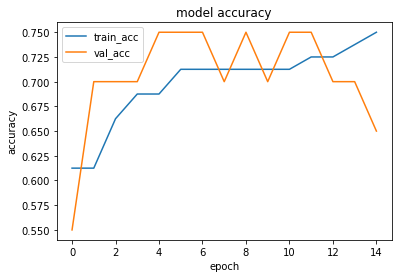

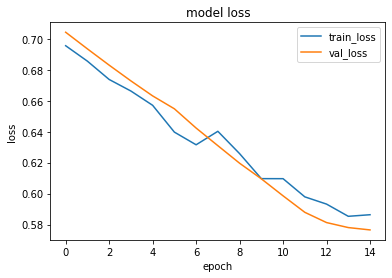

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.5864037]]


1it [00:00, 12671.61it/s]


prediction for video armflapping_3.mov is [[0.51238686]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.58764666]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.39936963]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.6188929]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.50733864]]
Epoch 1/75
3/3 [==============================] - 1s 238ms/step - loss: 0.7190 - accuracy: 0.3375 - precision_70: 0.2143 - recall_70: 0.1622 - val_loss: 0.7119 - val_accuracy: 0.4000 - val_precision_70: 0.5556 - val_recall_70: 0.3846
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6974 - accuracy: 0.3375 - precision_70: 0.2895 - recall_70: 0.2973 - val_loss: 0.6864 - val_accuracy: 0.6500 - val_precision_70: 0.8750 - val_recall_70: 0.5385
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6918 - accuracy: 0.5375 - precision_70: 0.5000 - recall_70: 0.5405 - val_loss: 0.6627 - val_accuracy: 0.6500 - val_precision_70: 0.7500 - val_recall_70: 0.6923
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6791 - accuracy: 0.6000 - precision_70: 0.5532 - recall_70: 0.7027 - val_loss: 0.6459 - val_accuracy: 0.7500 - val_precision_70: 0.7857 - val_recall_70: 0.8462
Epoch 5/75


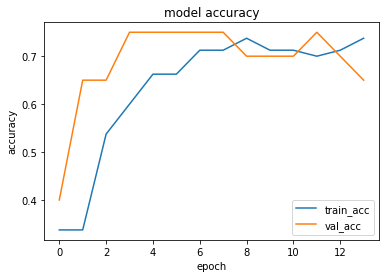

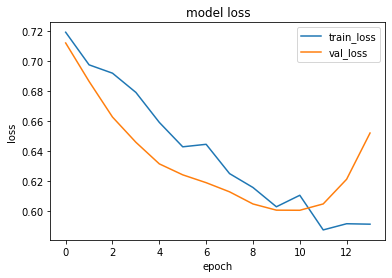

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.2132195]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_3.mov is [[0.5435322]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.16380018]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.131428]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.77175677]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.1251103]]
Epoch 1/75
3/3 [==============================] - 1s 236ms/step - loss: 0.6702 - accuracy: 0.6500 - precision_71: 0.5932 - recall_71: 0.8974 - val_loss: 0.6624 - val_accuracy: 0.6500 - val_precision_71: 0.6250 - val_recall_71: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6433 - accuracy: 0.7375 - precision_71: 0.6957 - recall_71: 0.8205 - val_loss: 0.6559 - val_accuracy: 0.6000 - val_precision_71: 0.6000 - val_recall_71: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6450 - accuracy: 0.7250 - precision_71: 0.6735 - recall_71: 0.8462 - val_loss: 0.6497 - val_accuracy: 0.6500 - val_precision_71: 0.6250 - val_recall_71: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6491 - accuracy: 0.7125 - precision_71: 0.6667 - recall_71: 0.8205 - val_loss: 0.6439 - val_accuracy: 0.6000 - val_precision_71: 0.6000 - val_recall_71: 0.8182
Epoch 5/75
3

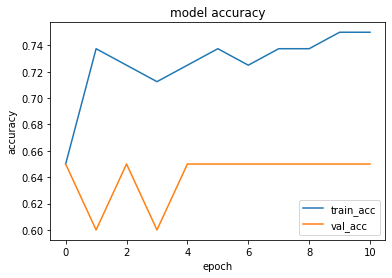

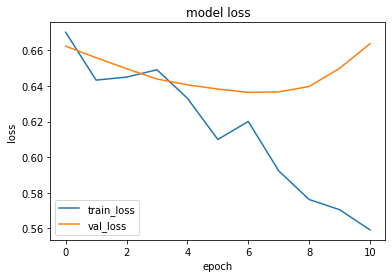

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.24305806]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.61393166]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.16664365]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.07448208]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.84264386]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.15256983]]
Epoch 1/75
3/3 [==============================] - 1s 232ms/step - loss: 0.7021 - accuracy: 0.4375 - precision_72: 0.3529 - recall_72: 0.1500 - val_loss: 0.6869 - val_accuracy: 0.6500 - val_precision_72: 0.6000 - val_recall_72: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6780 - accuracy: 0.6250 - precision_72: 0.6000 - recall_72: 0.7500 - val_loss: 0.6688 - val_accuracy: 0.6000 - val_precision_72: 0.5556 - val_recall_72: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6657 - accuracy: 0.5875 - precision_72: 0.5507 - recall_72: 0.9500 - val_loss: 0.6526 - val_accuracy: 0.6000 - val_precision_72: 0.5556 - val_recall_72: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6564 - accuracy: 0.6250 - precision_72: 0.5806 - recall_72: 0.9000 - val_loss: 0.6383 - val_accuracy: 0.6500 - val_precision_72: 0.6000 - val_recall_72: 0.9000
Epoch 5/75


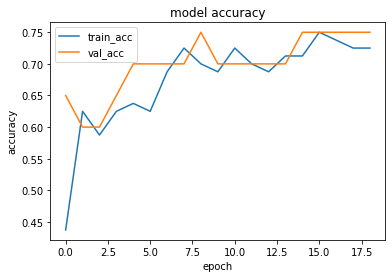

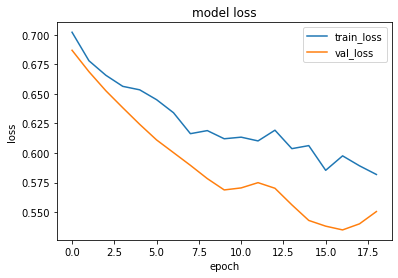

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.5493528]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.54823864]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.41779318]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.13751674]]


1it [00:00, 12336.19it/s]


prediction for video control_2.mov is [[0.7977009]]


1it [00:00, 12865.96it/s]


prediction for video control_3.mov is [[0.4180866]]
Epoch 1/75
3/3 [==============================] - 1s 239ms/step - loss: 0.6993 - accuracy: 0.6000 - precision_73: 0.6087 - recall_73: 0.6667 - val_loss: 0.6766 - val_accuracy: 0.7000 - val_precision_73: 0.5833 - val_recall_73: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6583 - accuracy: 0.7250 - precision_73: 0.7083 - recall_73: 0.8095 - val_loss: 0.6800 - val_accuracy: 0.6500 - val_precision_73: 0.5385 - val_recall_73: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6513 - accuracy: 0.6500 - precision_73: 0.6167 - recall_73: 0.8810 - val_loss: 0.6859 - val_accuracy: 0.4000 - val_precision_73: 0.3889 - val_recall_73: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6235 - accuracy: 0.6125 - precision_73: 0.5873 - recall_73: 0.8810 - val_loss: 0.6928 - val_accuracy: 0.5500 - val_precision_73: 0.4667 - val_recall_73: 0.8750
Epoch 5/75
3

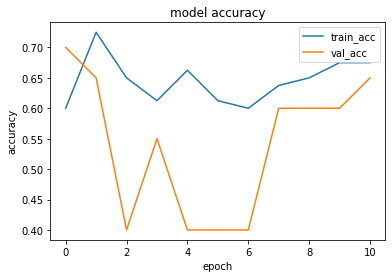

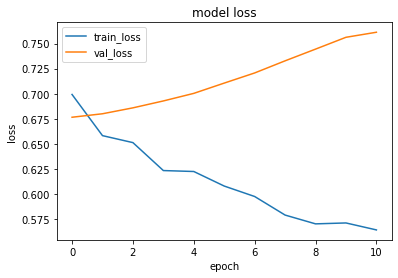

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.38447234]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.6118508]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.17683783]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.07817835]]


1it [00:00, 13662.23it/s]


prediction for video control_2.mov is [[0.8823437]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.15170348]]


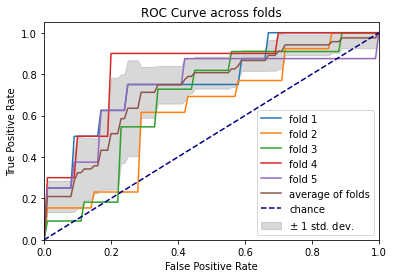

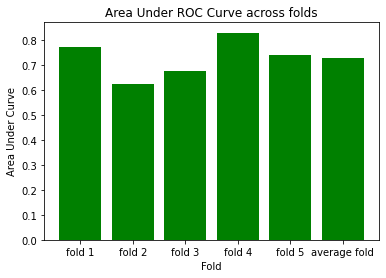

In [53]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6979 - accuracy: 0.4125 - precision_75: 0.4390 - recall_75: 0.4286 - val_loss: 0.6818 - val_accuracy: 0.5500 - val_precision_75: 0.4706 - val_recall_75: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6748 - accuracy: 0.5625 - precision_75: 0.5507 - recall_75: 0.9048 - val_loss: 0.6703 - val_accuracy: 0.5000 - val_precision_75: 0.4444 - val_recall_75: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 125ms/step - loss: 0.6494 - accuracy: 0.5750 - precision_75: 0.5541 - recall_75: 0.9762 - val_loss: 0.6622 - val_accuracy: 0.5000 - val_precision_75: 0.4444 - val_recall_75: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6505 - accuracy: 0.5500 - precision_75: 0.5395 - recall_75: 0.9762 - val_loss: 0.6461 - val_accuracy: 0.5000 - val_precision_75: 0.4444 - val_recall_75: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 137ms/step 

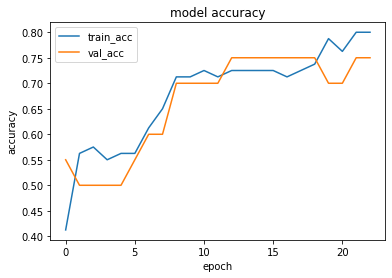

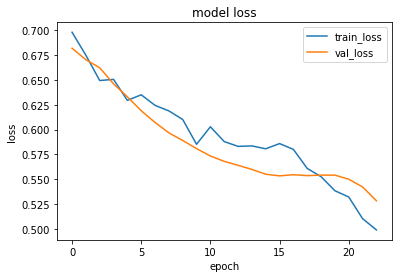

1it [00:00, 17331.83it/s]


prediction for video armflapping_1.mov is [[0.31007218]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.5826496]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.19851547]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.11861023]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.7798688]]


1it [00:00, 14027.77it/s]


prediction for video control_3.mov is [[0.17313793]]
Epoch 1/75
3/3 [==============================] - 1s 206ms/step - loss: 0.7008 - accuracy: 0.5250 - precision_76: 0.4839 - recall_76: 0.4054 - val_loss: 0.6813 - val_accuracy: 0.7000 - val_precision_76: 0.8182 - val_recall_76: 0.6923
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6973 - accuracy: 0.5875 - precision_76: 0.5625 - recall_76: 0.4865 - val_loss: 0.6630 - val_accuracy: 0.7500 - val_precision_76: 0.7857 - val_recall_76: 0.8462
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6659 - accuracy: 0.7000 - precision_76: 0.6444 - recall_76: 0.7838 - val_loss: 0.6492 - val_accuracy: 0.7500 - val_precision_76: 0.7857 - val_recall_76: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6535 - accuracy: 0.7250 - precision_76: 0.6667 - recall_76: 0.8108 - val_loss: 0.6361 - val_accuracy: 0.7500 - val_precision_76: 0.7857 - val_recall_76: 0.8462
Epoch 5/75


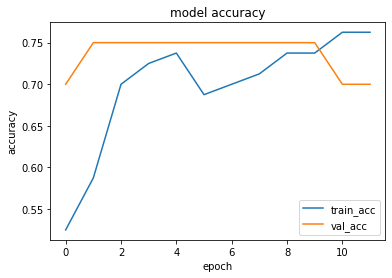

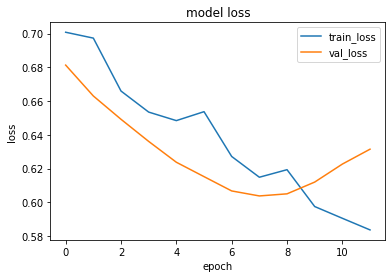

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.14832431]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.56103593]]


1it [00:00, 9892.23it/s]


prediction for video armflapping_2.mov is [[0.11791891]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.09485349]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.8365953]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.10701323]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.6918 - accuracy: 0.5625 - precision_77: 0.5526 - recall_77: 0.5385 - val_loss: 0.6817 - val_accuracy: 0.6500 - val_precision_77: 0.7000 - val_recall_77: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6837 - accuracy: 0.6500 - precision_77: 0.6667 - recall_77: 0.5641 - val_loss: 0.6706 - val_accuracy: 0.6500 - val_precision_77: 0.6429 - val_recall_77: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6698 - accuracy: 0.7125 - precision_77: 0.6739 - recall_77: 0.7949 - val_loss: 0.6613 - val_accuracy: 0.6500 - val_precision_77: 0.6429 - val_recall_77: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6593 - accuracy: 0.7375 - precision_77: 0.6957 - recall_77: 0.8205 - val_loss: 0.6543 - val_accuracy: 0.6500 - val_precision_77: 0.6429 - val_recall_77: 0.8182
Epoch 5/75


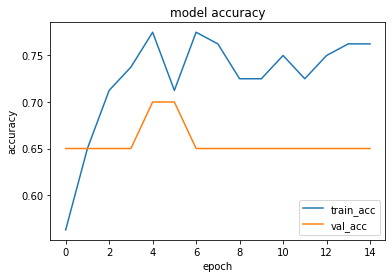

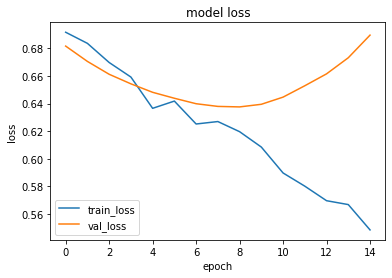

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.16721946]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.60256755]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.1355561]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.07920355]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.85318226]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.10431239]]
Epoch 1/75
3/3 [==============================] - 1s 196ms/step - loss: 0.7039 - accuracy: 0.5125 - precision_78: 0.5294 - recall_78: 0.2250 - val_loss: 0.6834 - val_accuracy: 0.7000 - val_precision_78: 0.7500 - val_recall_78: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6937 - accuracy: 0.5125 - precision_78: 0.5128 - recall_78: 0.5000 - val_loss: 0.6658 - val_accuracy: 0.6500 - val_precision_78: 0.5882 - val_recall_78: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6675 - accuracy: 0.5750 - precision_78: 0.5484 - recall_78: 0.8500 - val_loss: 0.6524 - val_accuracy: 0.6000 - val_precision_78: 0.5556 - val_recall_78: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6677 - accuracy: 0.5875 - precision_78: 0.5556 - recall_78: 0.8750 - val_loss: 0.6417 - val_accuracy: 0.6000 - val_precision_78: 0.5556 - val_recall_78: 1.0000
Epoch 5/75


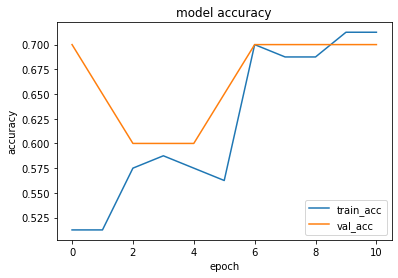

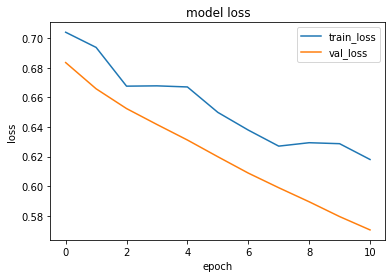

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.4083464]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.555054]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.29556054]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.17543525]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.75078154]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.21018869]]
Epoch 1/75
3/3 [==============================] - 1s 198ms/step - loss: 0.7111 - accuracy: 0.4375 - precision_79: 0.4444 - recall_79: 0.2857 - val_loss: 0.7044 - val_accuracy: 0.1500 - val_precision_79: 0.1538 - val_recall_79: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6809 - accuracy: 0.4625 - precision_79: 0.4909 - recall_79: 0.6429 - val_loss: 0.7028 - val_accuracy: 0.4000 - val_precision_79: 0.3889 - val_recall_79: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6616 - accuracy: 0.5625 - precision_79: 0.5493 - recall_79: 0.9286 - val_loss: 0.7039 - val_accuracy: 0.3500 - val_precision_79: 0.3684 - val_recall_79: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6546 - accuracy: 0.5875 - precision_79: 0.5634 - recall_79: 0.9524 - val_loss: 0.7073 - val_accuracy: 0.3500 - val_precision_79: 0.3684 - val_recall_79: 0.8750
Epoch 5/75


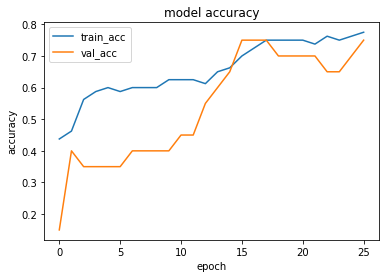

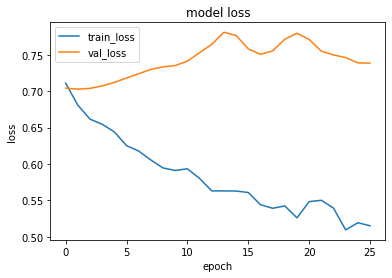

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.6928163]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.6016967]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.29945272]]


1it [00:00, 10866.07it/s]


prediction for video control_1.mov is [[0.03973913]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.8827543]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.18187937]]


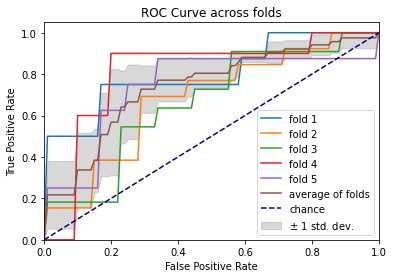

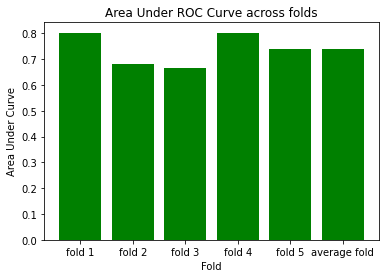

In [54]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 333ms/step - loss: 0.7121 - accuracy: 0.4625 - precision_81: 0.4857 - recall_81: 0.4048 - val_loss: 0.6951 - val_accuracy: 0.4000 - val_precision_81: 0.4000 - val_recall_81: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6860 - accuracy: 0.5375 - precision_81: 0.5342 - recall_81: 0.9286 - val_loss: 0.6743 - val_accuracy: 0.5500 - val_precision_81: 0.4706 - val_recall_81: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6759 - accuracy: 0.5375 - precision_81: 0.5352 - recall_81: 0.9048 - val_loss: 0.6599 - val_accuracy: 0.5500 - val_precision_81: 0.4706 - val_recall_81: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6545 - accuracy: 0.5875 - precision_81: 0.5652 - recall_81: 0.9286 - val_loss: 0.6478 - val_accuracy: 0.5500 - val_precision_81: 0.4706 - val_recall_81: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 135ms/step 

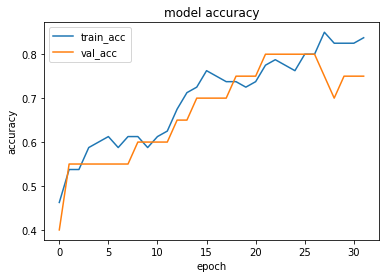

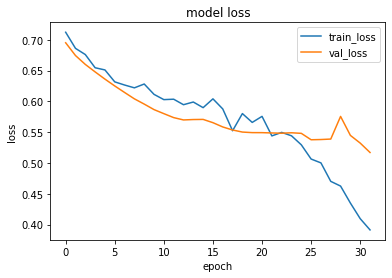

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4940407]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.5358076]]


In [55]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])